In [6]:
%load_ext autoreload

%autoreload 2

import os
from glob import glob
import subprocess
import shutil
import traceback
import random
import pickle
from os.path import join

import joblib
from concurrent.futures import ProcessPoolExecutor
import re

from backports import tempfile

import matplotlib
matplotlib.rcParams['savefig.dpi'] = 144
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import numpy.ma as ma

import psrchive

import pipe

plt.viridis()

import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logging.debug("test")

DEBUG:root:test


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
n_obs = {}
t_total = {}
tbw_total = {}
mjd_start = {}
mjd_end = {}

for d in sorted(glob(join("data","obs","*"))):
    M = pickle.load(open(join(d,"meta.pickle"),"rb"))
    k = M["tel"], M["band"]
    n_obs[k] = n_obs.setdefault(k,0) + 1
    t_total[k] = t_total.setdefault(k,0) + M["length"]
    mjd_start[k] = min(mjd_start.setdefault(k,1e10),M["mjd"])
    mjd_end[k] = max(mjd_start.setdefault(k,0),M["mjd"])
    #tbw_total[k] = 

In [11]:
print("{tel:5s}{band:>5s}{n:>5s}{t:>10s}{m:>14s}   {r:^12s}".format(
        tel="tel", band="band", n="n", t="T (h)", m="mean T (min)",
        r="MJD range"))
print("-"*54)
for k in sorted(n_obs.keys()):
    tel, band = k
    n = n_obs[k]
    t = t_total[k]/3600
    m = t/n*60
    s, e = mjd_start[k], mjd_end[k]
    print("{tel:5s}{band:5d}{n:5d}{t:10.1f}{m:14.1f}   {s:5.0f}--{e:5.0f}".format(**locals()))

tel   band    n     T (h)  mean T (min)    MJD range  
------------------------------------------------------
AO     350    3       0.9          17.7   57059--57432
AO     430   36      12.9          21.5   56071--57833
AO    1400   92      58.9          38.4   55990--57833
AO    2000    7       3.2          27.0   56769--57552
AO    3000    1       0.7          40.3   56782--56782
GBT   1400  172     236.0          82.3   55962--57888
WSRT   350   20      17.3          52.0   55960--56485
WSRT  1400  439     836.7         114.4   55957--56496


In [46]:
zaps = {}
nsubint = {}
nchans = {}
for d in sorted(glob(join("data","obs","*"))):
    M = pickle.load(open(join(d,"meta.pickle"),"rb"))
    k = M["tel"], M["band"]
    if "zaps" not in M:
        continue
    if k not in nchans:
        nchans[k] = M["nchan"]
    else:
        if nchans[k] != M["nchan"]:
            print "Channel discrepancy for %s: %d != %d" % (k, M["nchan"], nchans[k])
            continue
    zaps.setdefault(k, np.zeros(M["nchan"]))
    nsubint.setdefault(k, 0)
    nsubint[k] += M["nsubint"]
    zaps[k] += np.array(M["zaps"])

Channel discrepancy for ('WSRT', 1400): 384 != 512
Channel discrepancy for ('WSRT', 1400): 256 != 512
Channel discrepancy for ('WSRT', 1400): 448 != 512
Channel discrepancy for ('WSRT', 1400): 448 != 512
Channel discrepancy for ('WSRT', 1400): 448 != 512
Channel discrepancy for ('WSRT', 1400): 448 != 512
Channel discrepancy for ('WSRT', 1400): 384 != 512
Channel discrepancy for ('WSRT', 1400): 448 != 512
Channel discrepancy for ('WSRT', 1400): 448 != 512
Channel discrepancy for ('WSRT', 1400): 448 != 512
Channel discrepancy for ('WSRT', 1400): 384 != 512
Channel discrepancy for ('WSRT', 1400): 448 != 512
Channel discrepancy for ('WSRT', 1400): 448 != 512
Channel discrepancy for ('WSRT', 1400): 448 != 512
Channel discrepancy for ('WSRT', 1400): 448 != 512
Channel discrepancy for ('WSRT', 1400): 448 != 512
Channel discrepancy for ('WSRT', 1400): 320 != 512
Channel discrepancy for ('WSRT', 1400): 448 != 512
Channel discrepancy for ('WSRT', 1400): 448 != 512
Channel discrepancy for ('WSRT'

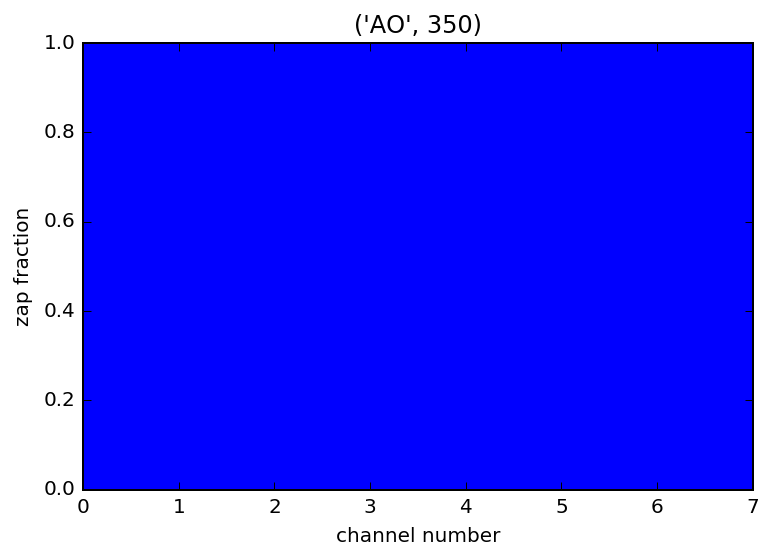

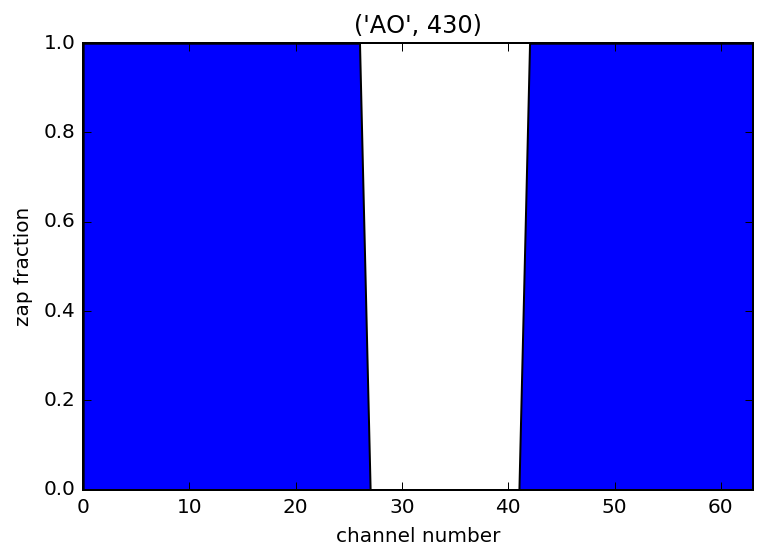

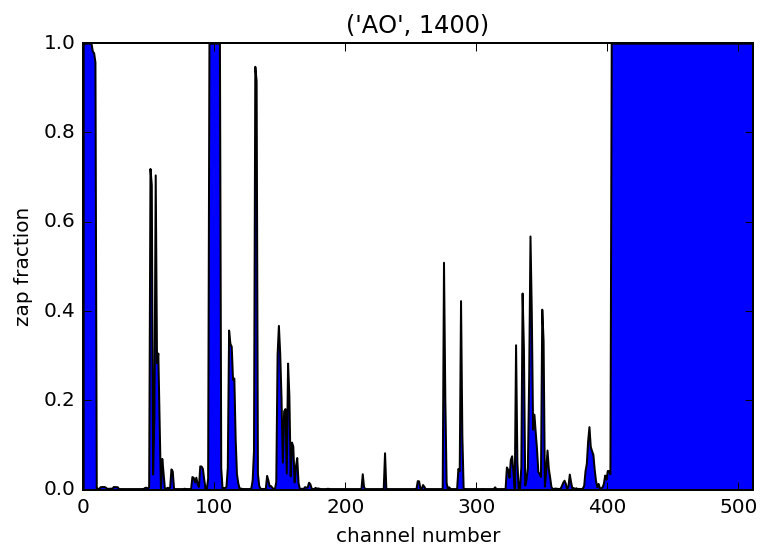

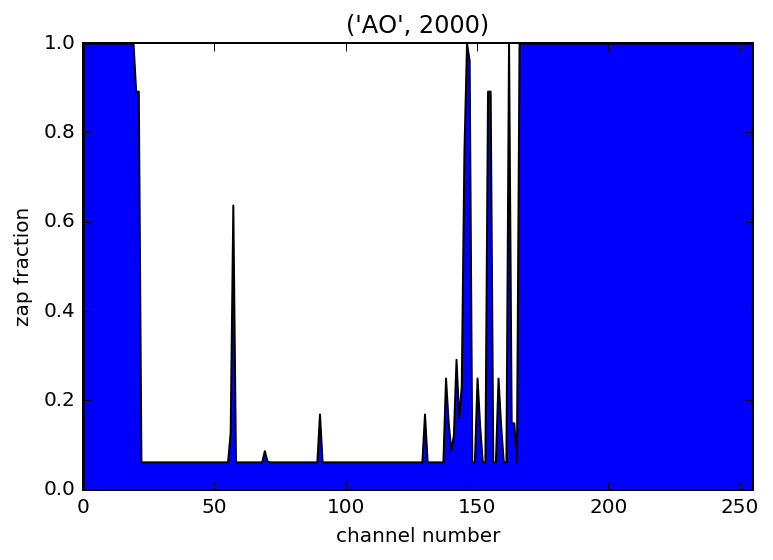

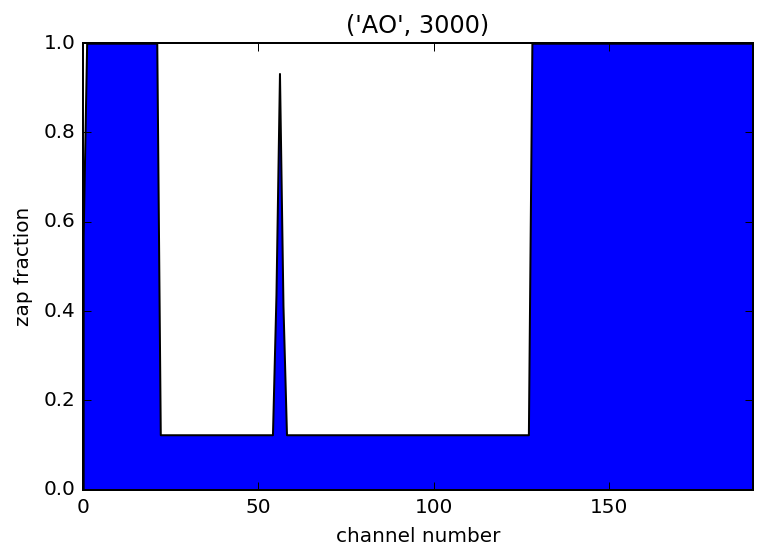

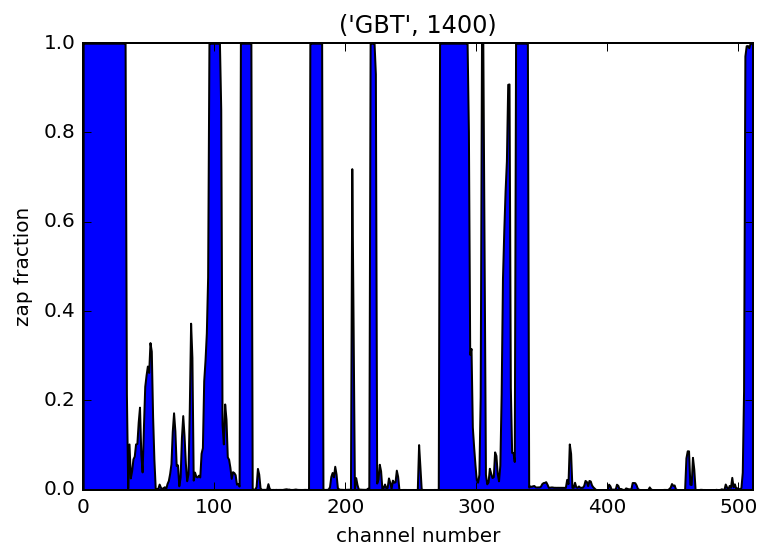

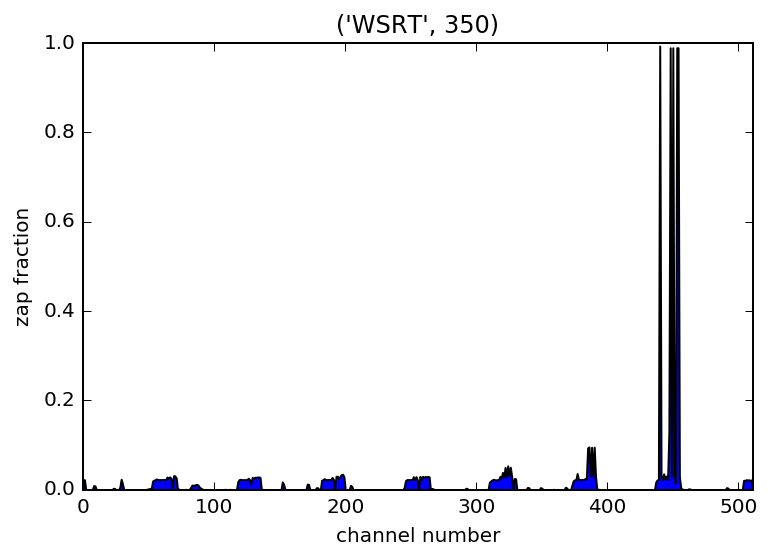

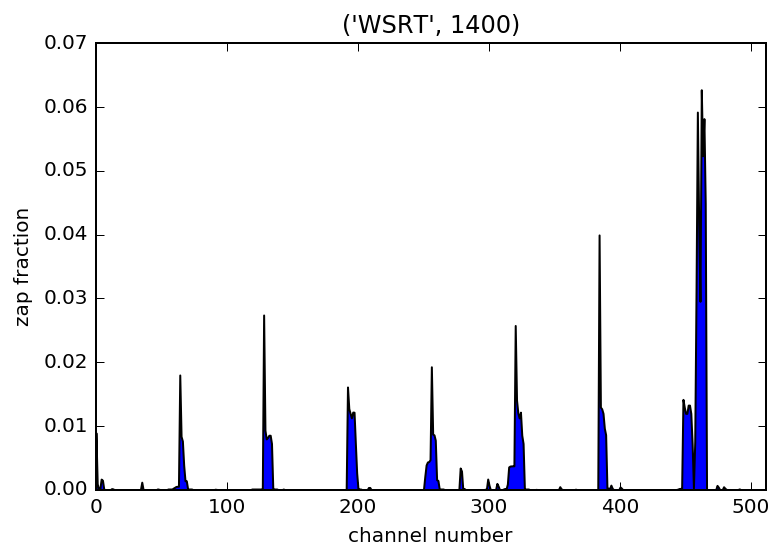

In [47]:
for k in sorted(zaps.keys()):
    plt.figure()
    plt.title(str(k))
    #plt.plot(zaps[k]/nsubint[k],drawstyle="steps-mid")
    plt.gca().fill_between(np.arange(len(zaps[k])),zaps[k]/nsubint[k])
    plt.xlim(0,len(zaps[k])-1)
    plt.xlabel("channel number")
    plt.ylabel("zap fraction")

In [63]:
longest = {}
for d in sorted(glob(join("data","obs","*"))):
    M = pickle.load(open(join(d,"meta.pickle"),"rb"))
    k = M["tel"], M["band"]
    if (k not in longest
        or longest[k]["length"]<M["length"]):
        longest[k] = M


In [64]:
for k in longest:
    l = longest[k]
    print k, l["nsubint"], l["length"], l["obs_dir"]

('AO', 2000) 63 4576.99288437 /psr_archive/hessels/archibald/0337+17/obs/56768.79_AO_2000
('AO', 350) 168 1796.86460998 /psr_archive/hessels/archibald/0337+17/obs/57058.98_AO_350
('GBT', 1400) 69 42646.8976767 /psr_archive/hessels/archibald/0337+17/obs/56321.01_GBT_1400
('WSRT', 1400) 3239 32389.792704 /psr_archive/hessels/archibald/0337+17/obs/56262.88_WSRT_1400
('AO', 1400) 35 8877.52792533 /psr_archive/hessels/archibald/0337+17/obs/56025.79_AO_1400
('AO', 3000) 44 2416.49165356 /psr_archive/hessels/archibald/0337+17/obs/56781.71_AO_3000
('AO', 430) 261 2791.53515592 /psr_archive/hessels/archibald/0337+17/obs/56070.64_AO_430
('WSRT', 350) 1799 17988.84864 /psr_archive/hessels/archibald/0337+17/obs/56479.20_WSRT_350


In [49]:
M.keys()

['mjd',
 'zaps',
 'par',
 'nchan',
 'tel',
 'name',
 'centre_frequency',
 'band',
 'align_files',
 'clean_files',
 'obs_dir',
 'P',
 'length',
 'nsubint',
 'max_smearing',
 'receiver',
 'input_files']

In [55]:
M["centre_frequency"]

320.65234375

In [56]:
M["tel"]

'AO'

In [69]:
M["name"]

'57432.00_AO_350'

In [57]:
cfs = []
for d in sorted(glob(join("data","obs","*"))):
    M = pickle.load(open(join(d,"meta.pickle"),"rb"))
    if M["tel"]=="AO" and M["band"]==1400:
        cfs.append(M["centre_frequency"])

(array([ 54.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
          0.,   0.,   0.,   7.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          2.]),
 array([ 1380.78125,  1384.28125,  1387.78125,  1391.28125,  1394.78125,
         1398.28125,  1401.78125,  1405.28125,  1408.78125,  1412.28125,
         1415.78125,  1419.28125,  1422.78125,  1426.28125,  1429.78125,
         1433.28125,  1436.78125,  1440.28125,  1443.78125,  1447.28125,
         1450.78125,  1454

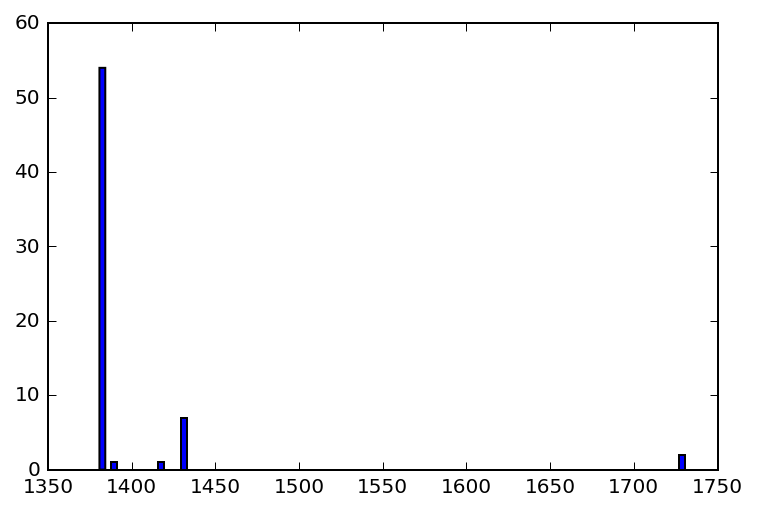

In [59]:
plt.hist(cfs,bins=100)

In [ ]:
# AO 430: -30
# AO 1400: +30 - PUPPI pol same as Mock 
# GBT 1400: +30
# WSRT 1400: +30 
# WSRT 350: -30


In [66]:
processing_runs = set()
toa_runs = set()
for d in sorted(glob(join("data","obs","*"))):
    for sd in os.listdir(d):
        if not os.path.isdir(join(d,sd)):
            continue
        processing_runs.add(sd)
        for ssd in os.listdir(join(d,sd)):
            if not os.path.isdir(join(d,sd,ssd)):
                continue
            toa_runs.add((sd,ssd))

In [67]:
sorted(processing_runs)

['toa-testing', 'wideband']

In [68]:
sorted(toa_runs)

[]

In [82]:
snrs = {}
processing_name = "wideband"
toa_name = "normal"
for d in sorted(glob(join("data","obs","*",processing_name,toa_name))):
    M = pickle.load(open(join(d,"..","process.pickle"),"rb"))
    M2 = pickle.load(open(join(d,"summary.pickle"),"rb"))
    k = M["tel"], M["band"]
    if k not in snrs:
        snrs[k] = []
    snrs[k].append((M2['snr_sum'],M['name']))
for k in snrs:
    snrs[k].sort()
    snrs[k] = snrs[k][::-1]
    print k, snrs[k][:20]

('GBT', 1400) [(72147.438642543886, '56412.76_GBT_1400'), (68267.325089264225, '56321.01_GBT_1400'), (67777.17230122973, '56142.50_GBT_1400'), (66221.79141810436, '56234.25_GBT_1400'), (60884.632224439782, '56506.42_GBT_1400'), (49579.207341495159, '56690.92_GBT_1400'), (45528.897719101544, '56527.34_GBT_1400'), (12146.533551015165, '56034.89_GBT_1400'), (9897.9259404241329, '55997.81_GBT_1400'), (9520.1487729697292, '56550.27_GBT_1400'), (9118.7006650784933, '56702.91_GBT_1400'), (8513.3373494007865, '56039.69_GBT_1400'), (8267.1539876842216, '56149.48_GBT_1400'), (6800.9954815729607, '56611.42_GBT_1400'), (6719.5440608307536, '56135.35_GBT_1400'), (6693.5811813177979, '56328.02_GBT_1400'), (6472.3935072936192, '56021.73_GBT_1400'), (6182.0187857994479, '55964.00_GBT_1400'), (6164.2753797032292, '56029.01_GBT_1400'), (6107.000276718747, '56047.97_GBT_1400')]
('WSRT', 1400) [(1717.3127456776506, '56262.88_WSRT_1400'), (1677.5742954502543, '56261.84_WSRT_1400'), (1366.631101781951, '560

In [79]:
M2.keys()

['gtp_weights',
 'topo_toa',
 'toa_info',
 'yfp_data',
 'meta',
 'snr_data',
 'snr_weight',
 't_fit',
 'gtp_data',
 'max_f',
 'prof_data',
 'yfp_start_end',
 'text_format',
 'min_f',
 'te',
 'prefit_sec',
 'smear_data',
 'prof_weights',
 'p_dir',
 'uncertainty',
 'snr_sum',
 't_values',
 'bary_freq']

In [77]:
M2['snr_data']

[(0, 589.9962240000029, masked_array(data =
   [[2.292452309884767]],
               mask =
   [[False]],
         fill_value = 1e+20))]

In [4]:
Mi = None
for d in sorted(glob(join("data","obs","*"))):
    M = pickle.load(open(join(d,"meta.pickle"),"rb"))
    k = M["tel"], M["band"]
    if k==("AO",2000):
        Mi = M
        print d, M["length"]

data/obs/56768.75_AO_2000 1525.68202964
data/obs/56768.79_AO_2000 4576.99288437
data/obs/56781.75_AO_2000 4024.0743831
data/obs/57317.30_AO_2000 307.19060332
data/obs/57375.14_AO_2000 307.190255681
data/obs/57431.99_AO_2000 307.190507767


In [5]:
Mi = None
for d in sorted(glob(join("data","obs","*"))):
    M = pickle.load(open(join(d,"meta.pickle"),"rb"))
    k = M["tel"], M["band"]
    if k==("AO",3000):
        Mi = M
        print d, M["length"]

data/obs/56781.71_AO_3000 2416.49165356
